In [ ]:
#importing all needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import glob
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import applications
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras import applications
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras import backend as K
import gc
from tensorflow.keras.models import Model
import pickle

In [ ]:
train_dir="BTK_Studios"
test_dir="../input/re-arranged-data/sign_data/Dataset/test"

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os


In [4]:
# Placeholder function for loading your signature dataset
def load_signature_dataset():
    # X: images (num_samples, height, width, 1)
    # y: label masks (num_samples, height, width, 3)
    # where 3 = {pen_lift, pen_cross, pen_curve}
    X = np.random.rand(100, 128, 128, 1).astype(np.float32)
    y = np.random.randint(0, 2, (100, 128, 128, 3)).astype(np.float32)
    return X, y

X, y = load_signature_dataset()

# Normalize images
X = X / 255.0


In [9]:
#IF EVERYTHING STARTS TO BREAK IT IS MOST LIKELY BECAUSE OF THIS CELL RIGHT HERE
def load_signature_dataset(image_dir, label_dir, target_size=(128, 128)):
    """
    Loads signature images and corresponding label masks.
    Each label mask should have 3 channels for (pen_lift, pen_cross, pen_curve).
    """

    X = []
    y = []

    # Sort filenames to ensure matching order
    image_files = sorted(os.listdir(image_dir))

    #FILES MUST BE NAMED IN SIMILAR WAY TO ENSURE THAT EVERYTHING IS MARKED CORRECTLY
    for filename in image_files:
        image_path = os.path.join(image_dir, filename)
        label_path = os.path.join(label_dir, filename)

        # Skip if label missing
        if not os.path.exists(label_path):
            print(f"Warning: Label for {filename} not found, skipping.")
            continue

        # Load grayscale signature image
        img = load_img(image_path, color_mode='grayscale', target_size=target_size)
        img_arr = img_to_array(img) / 255.0   # normalize to [0,1]
        X.append(img_arr)

        # Load corresponding label mask (should be RGB: 3 channels)
        mask = load_img(label_path, color_mode='rgb', target_size=target_size)
        mask_arr = img_to_array(mask) / 255.0 # normalize
        y.append(mask_arr)

    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)

    print(f"Loaded {len(X)} samples from {image_dir}")
    return X, y


In [6]:
def create_signature_cnn(input_shape=(128, 128, 1)):
    inputs = layers.Input(shape=input_shape)
    
    # Encoder
    c1 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    c1 = layers.MaxPooling2D((2,2))(c1)

    c2 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(c1)
    c2 = layers.MaxPooling2D((2,2))(c2)

    c3 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(c2)
    
    # Decoder
    u1 = layers.UpSampling2D((2,2))(c3)
    u1 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(u1)
    
    u2 = layers.UpSampling2D((2,2))(u1)
    u2 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(u2)
    
    outputs = layers.Conv2D(3, (1,1), activation='sigmoid')(u2)
    
    model = models.Model(inputs, outputs)
    return model

model = create_signature_cnn()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 3)    │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 185,027 (722.76 KB)

 Trainable params: 185,027 (722.76 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X, y, epochs=10, batch_size=8, validation_split=0.2)


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 226ms/step - accuracy: 0.3023 - loss: 0.6931 - val_accuracy: 0.6161 - val_loss: 0.6931
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 177ms/step - accuracy: 0.4010 - loss: 0.6931 - val_accuracy: 0.6248 - val_loss: 0.6931
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 193ms/step - accuracy: 0.6237 - loss: 0.6931 - val_accuracy: 0.5901 - val_loss: 0.6931
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - accuracy: 0.1715 - loss: 0.6931 - val_accuracy: 0.6096 - val_loss: 0.6931
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step - accuracy: 0.6236 - loss: 0.6931 - val_accuracy: 0.6248 - val_loss: 0.6931
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step - accuracy: 0.4334 - loss: 0.6931 - val_accuracy: 0.1252 - val_loss: 0.6931
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 188ms/step - accuracy: 0.1737 - loss: 0.6931 - val_accuracy: 0.6210 - val_loss: 0.6931
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step - accuracy: 0.6248 - loss: 0.6931 - val_accuracy: 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


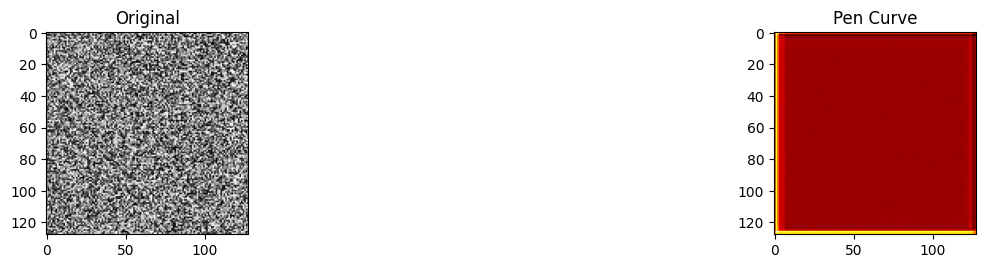

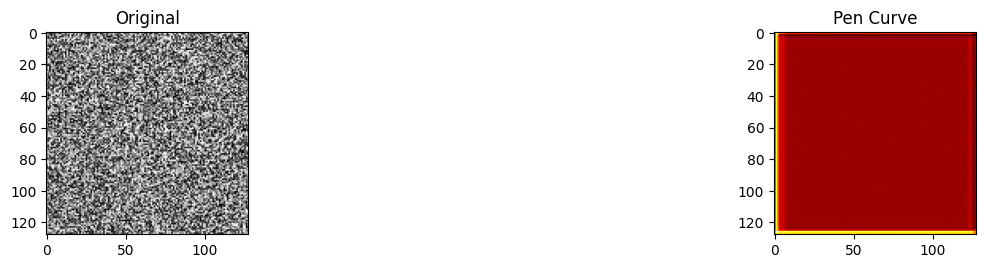

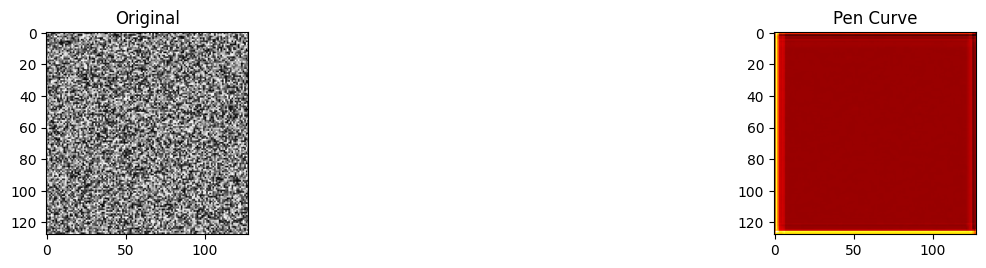

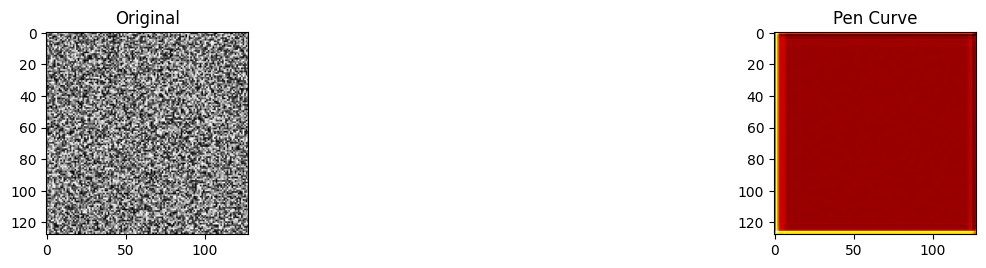

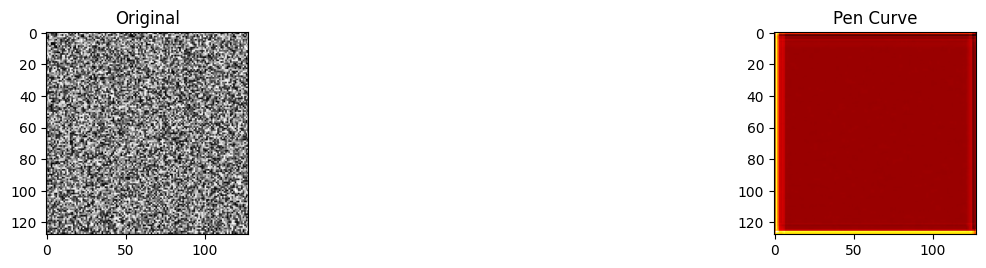

In [8]:
preds = model.predict(X[:5])

for i in range(5):
    plt.figure(figsize=(12,4))
    plt.subplot(1,4,1)
    plt.title("Original")
    plt.imshow(X[i].squeeze(), cmap='gray')
    
    # plt.subplot(1,4,2)
    # plt.title("Pen Lift")
    # plt.imshow(preds[i][:,:,0], cmap='hot')
    
    # plt.subplot(1,4,3)
    # plt.title("Pen Cross")
    # plt.imshow(preds[i][:,:,1], cmap='hot')
    
    plt.subplot(1,4,4)
    plt.title("Pen Curve")
    plt.imshow(preds[i][:,:,2], cmap='hot')
    plt.show()
